# Emotion Recognition with CNNs
Andrea Mansi (137857)

Christian Cagnoni (137690)

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plot
from PIL import Image
import torchvision.transforms as T
import time

## 1. Data import and preprocessing

The input dataset is from FER2013 competition.

Dataset URL: https://www.kaggle.com/ashishpatel26/facial-expression-recognitionferchallenge

In [2]:
# Data reading from csv file
# Insert your path here:
data_path = "C:/Users/Mansitos_Picci/Desktop/fer2013.csv"
dataframe = pd.read_csv(data_path)

# Printing dataset main infos
print("Shape:" + str(dataframe.shape))
print(dataframe.head(4))

Shape:(35887, 3)
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training


Counting and plotting all the emotions. Dataset is not "balanced" some emotions are less present.

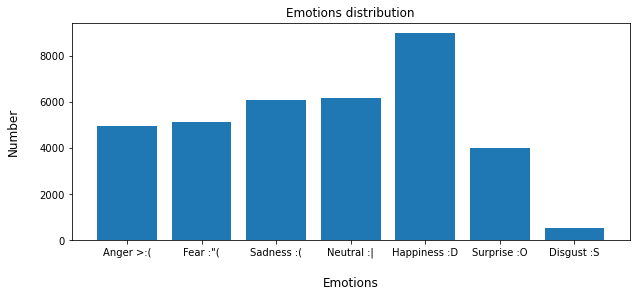

In [3]:
emotions_labels_to_text = {0:'Anger >:(', 1:'Disgust :S', 2:'Fear :"(', 3:'Happiness :D', 4: 'Sadness :(', 5: 'Surprise :O', 6: 'Neutral :|'}

emotions_counts = dataframe['emotion'].value_counts(sort=False).reset_index()
emotions_counts.columns = ['emotion', 'number']
emotions_counts['emotion'] = emotions_counts['emotion'].map(emotions_labels_to_text)

plot.figure(figsize=(10, 4))
plot.bar(emotions_counts.emotion, emotions_counts.number)
plot.title('Emotions distribution')
plot.xlabel('\nEmotions', fontsize=12)
plot.ylabel('Number\n', fontsize=12)
plot.show()

Processing the input data and preparing test and validation sets. Public test will be used, private test will be ignored.

In [4]:
# Taking Training data (dataset is already subdivided into training and test (private and public))
data_train = dataframe[dataframe.Usage == "Training"]
data_test  = dataframe[dataframe.Usage == "PublicTest"]

# Processing the pixel column: converting the list (in which each pixel value is separated by a whitespace) into a list of ints
imgs_train = pd.DataFrame(data_train.pixels.str.split(" ").tolist())
imgs_test  = pd.DataFrame(data_test.pixels.str.split(" ").tolist())

# Float conversion
imgs_train = imgs_train.values.astype(float)
imgs_test = imgs_test.values.astype(float)

# reshaping to match model input
x_train = imgs_train.reshape(-1, 48 , 48 ,1)
x_test = imgs_test.reshape(-1, 48, 48, 1)

# taking label train column and converting into monodimensional array
y_train = data_train["emotion"].values
y_test = data_test["emotion"].values

Dataset augmentation phase. This phase enlarge the dataset by applying transformations to images. It can be skipped in order to use the raw input dataset. Enlarged dataset will require more time for training phase.

In [5]:
# set to TRUE if you want the test dataset to be enlarged by applying transformations to images
enanche_dataset_flag = True

Executing dataset augmentation... phase: 1
Number of starting images: 28709
Showing a random starting image:


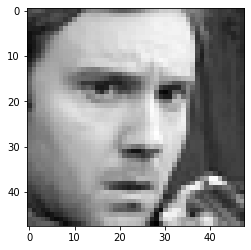

In [6]:
if(enanche_dataset_flag):
    print("Executing dataset augmentation... phase: 1")
    img=[]

    def arrayToImage(array):
        new_im = Image.new("L", (48,48))

        x_offset = 0
        for im in array:
          new_im.paste(im, (x_offset,0))
          x_offset += im.size[0]

        img.append((new_im.rotate(-90)).transpose(Image.FLIP_LEFT_RIGHT))

    for i in range(len(x_train)):
        tmp_img=[]
        for j in range(len(x_train[i])):
            tmp_img.append(Image.fromarray(x_train[i][j]))
        arrayToImage(tmp_img)

    
    print("Number of starting images: " + str(len(img)))
    print("Showing a random starting image:")
    plot.imshow(img[0],cmap='gray')
else:
    print("Dataset augmentation skipped...")

In [7]:
if(enanche_dataset_flag):
    print("Executing dataset augmentation... phase: 2")
    torch.manual_seed(42)

    transformedImages=[]
    transformedLabels=[]

    perspective_transfromer = T.RandomPerspective(distortion_scale=0.5,p=0.5)
    rotater = T.RandomRotation(degrees=(-90, 90))
    
    for i in range(len(img)):
        transformedImages.append(perspective_transfromer(img[i]))
        transformedLabels.append(y_train[i])
    for i in range(len(img)):
        transformedImages.append(rotater(img[i]))
        transformedLabels.append(y_train[i])

Executing dataset augmentation... phase: 2


Executing dataset augmentation... phase: 3
Number of final images: 86127
Showing a random transformed image:


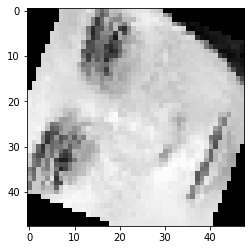

In [8]:
if(enanche_dataset_flag):
    x_train_ransformed=[]
    print("Executing dataset augmentation... phase: 3")

    for i in transformedImages:
        x_train_ransformed.append((np.asanyarray(i)).reshape(48,48,1))

    x_train = np.concatenate((x_train,np.array(x_train_ransformed)))
    y_train = np.concatenate((y_train,np.array(transformedLabels)))
    
    print("Number of final images: " + str(len(x_train)))
    print("Showing a random transformed image:")
    plot.imshow(transformedImages[-1],cmap='gray')

Normalizing the emotions img. count. Dataset is not balanced, some emotions have a lower abs. frequency compared to others (disgust is the extreme example of this).

This phase is optionally executed. It takes the abs. frequency of the less frequent emotion and randomly discards imgs. from other classes in order to have the same amount of input data for each emotion. 

Note that this can improve accuracy because input data will be more balanced but at the same time some information is lost (so accuracy can decrease).

In [9]:
minAbsFreq=min(data_train["emotion"].value_counts())
originalShape=imgs_train.shape

number_of_applied_transformations = 3
originalShapeAugmented=(originalShape[0]*number_of_applied_transformations,originalShape[1])
lowerBound=minAbsFreq*number_of_applied_transformations

x_train_norm=x_train.reshape(originalShapeAugmented)

tmpSer=[]
merge=""
old_percentage = 0

for i in range(len(x_train)):
    new_percentage = int((i/len(x_train_norm))*100)
    if(old_percentage < new_percentage):
        print("Status:" + str(new_percentage) + "%")
        old_percentage = new_percentage
    for j in range(len(x_train[i])):
        merge=merge+" "+str(x_train_norm[i][j])
    tmpSer.append(merge)
    merge=""
print("Status: 100%")
ser=pd.Series(tmpSer)

d={'emotion':y_train,'pixels':ser}
augmentedDF=pd.DataFrame(data=d)

Status:1%
Status:2%
Status:3%
Status:4%
Status:5%
Status:6%
Status:7%
Status:8%
Status:9%
Status:10%
Status:11%
Status:12%
Status:13%
Status:14%
Status:15%
Status:16%
Status:17%
Status:18%
Status:19%
Status:20%
Status:21%
Status:22%
Status:23%
Status:24%
Status:25%
Status:26%
Status:27%
Status:28%
Status:29%
Status:30%
Status:31%
Status:32%
Status:33%
Status:34%
Status:35%
Status:36%
Status:37%
Status:38%
Status:39%
Status:40%
Status:41%
Status:42%
Status:43%
Status:44%
Status:45%
Status:46%
Status:47%
Status:48%
Status:49%
Status:50%
Status:51%
Status:52%
Status:53%
Status:54%
Status:55%
Status:56%
Status:57%
Status:58%
Status:59%
Status:60%
Status:61%
Status:62%
Status:63%
Status:64%
Status:65%
Status:66%
Status:67%
Status:68%
Status:69%
Status:70%
Status:71%
Status:72%
Status:73%
Status:74%
Status:75%
Status:76%
Status:77%
Status:78%
Status:79%
Status:80%
Status:81%
Status:82%
Status:83%
Status:84%
Status:85%
Status:86%
Status:87%
Status:88%
Status:89%
Status:90%
Status:91%
Status:9

Creating model input: data is converted into tensors and then loaded into 2 dataloaders: train and test dataloaders.

In [10]:
tensor_ids_train = torch.Tensor(x_train)
labels_train = torch.LongTensor(y_train)
train_dataset = TensorDataset(tensor_ids_train, labels_train)

tensor_ids_test = torch.Tensor(x_test)
labels_test = torch.LongTensor(y_test)
test_dataset = TensorDataset(tensor_ids_test, labels_test)

In [11]:
batch_size = 128

train_dataloader = DataLoader(train_dataset,
                              sampler = RandomSampler(train_dataset),
                              batch_size = batch_size)
test_dataloader = DataLoader(test_dataset,
                              sampler = RandomSampler(test_dataset),
                              batch_size = batch_size)

Defining useful functions for tensor printing

In [12]:
def showImage(image,size,index,description):
    img = image.reshape(size,size)
    plot.axis("off")
    #print(description)
    plot.figure(index)
    plot.imshow(img, cmap ='gray')

# This function can be used to see a tensor as an image
def showTensorAsImage(tensor,size,index,description):
      tensor_copy = tensor.to(torch.device("cpu"))
      tensor_copy = tensor_copy.detach()
      showImage(np.array(tensor_copy[0][0]),size,index,description)
     

Checking machine devices. Enable CUDA computation if available.

In [13]:
print("Is GPU available?")
if(torch.cuda.is_available()):
    print("Yes :)")
else:
    print("No :(")
print("")
print("Is cudnn backend enabled?")
print(torch.backends.cudnn.enabled)
print("")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training will run on device: " + str(device))
if(str(device)=="cuda:0"):print( torch.cuda.get_device_name(0))

Is GPU available?
Yes :)

Is cudnn backend enabled?
True

Training will run on device: cuda:0
NVIDIA GeForce RTX 3070 Ti


## 2. Defining the Model

The following model is the last iteration/version. Previous versions are not included but informations are included in the PDF report.

In [14]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1,80,kernel_size=5,padding=2) # First convolutional layer
      self.conv1_bn = nn.BatchNorm2d(80)
      self.pool = nn.MaxPool2d(kernel_size=2,stride=2) # Pooling layer
      self.conv2 = nn.Conv2d(80,140,kernel_size=5,padding=2) # Second convolutional layer
      self.conv2_bn = nn.BatchNorm2d(140)
      self.conv3 = nn.Conv2d(140,200,kernel_size=3,padding=1) # Third convolutional layer
      self.conv3_bn = nn.BatchNorm2d(200)
      self.conv4 = nn.Conv2d(200,250,kernel_size=3,padding=1) # Fourth convolutional layer
      self.conv4_bn = nn.BatchNorm2d(250)
      self.fc1 = nn.Linear(250*3*3,160) # First linear layer
      self.fc1_bn = nn.BatchNorm1d(160)
      self.fc2 = nn.Linear(160,70) # Second linear layer
      self.fc2_bn = nn.BatchNorm1d(70)
      self.fc3 = nn.Linear(70,20) # Third linear layer
      self.fc3_bn = nn.BatchNorm1d(20)
      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim=1)
      self.drop = nn.Dropout(p=0.25)

    # Applying step-by-step the image classification architecture to the input
    def forward(self, x):     
      x = self.conv1(x) 
      x = self.conv1_bn(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.drop(x)
        
      if(net.training == False):
        showTensorAsImage(x,24,1,description="Random tensor from 1st conv. layer")
        
      x = self.conv2(x)  
      x = self.conv2_bn(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.drop(x)
    
      if(net.training == False):
        showTensorAsImage(x,12,2,description="Random tensor from 2nd conv. layer")
    
      x = self.conv3(x)
      x = self.conv3_bn(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.drop(x)
        
      if(net.training == False):
        showTensorAsImage(x,6,3,description="Random tensor from 3rd conv. layer")
        
      x = self.conv4(x)
      x = self.conv4_bn(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.drop(x)
    
      x = x.reshape(x.size(0),250*3*3) # Modifying the shape of x to make the tensor fit in the first linear
      x = self.fc1(x)
      x = self.fc1_bn(x)
      x = self.relu(x) # Applying the activation function
      x = self.drop(x)
    
      x = self.fc2(x)
      x = self.fc2_bn(x)
      x = self.relu(x) # Applying the activation function
      x = self.drop(x)
        
      x = self.fc3(x)
      x = self.fc3_bn(x)
      x = self.softmax(x)
      return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(80, 140, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(140, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2250, out_features=160, bias=True)
  (fc1_bn): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=160, out_features=70, bias=True)
  

#### Train function definition

In [15]:
# Moving model to device (to cuda if available)
net = net.to(device)
net.train()

criterion = nn.CrossEntropyLoss() # Defining the criterion

#optimizer = optim.SGD(net.parameters(),momentum=0.9,lr=0.001) # Defining the optimizer
optimizer = optim.Adam(net.parameters(),lr=0.003)

start_time = time.time()

for epoch in range(350): #Looping over the dataset three times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        
        inputs, labels = data # The input data is a list [inputs, labels]

        inputs = inputs.permute(0, 3, 1, 2) # permuting the input to match the order used by pytorch
        
        # Moving to device (to cuda if available)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() # Setting the parameter gradients to zero

        outputs = net(inputs) # Forward pass
        loss = criterion(outputs,labels) # Applying the criterion
        loss.backward() # Backward pass
        optimizer.step() # Optimization step

        running_loss += loss.item() # Updating the running loss
        if i % len(train_dataloader) == len(train_dataloader)-1:  # Printing the running loss
            print('[epoch: %d, mini-batch: %d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / len(train_dataloader)))
            running_loss = 0.0

print('Finished Training :)')
print("Training time: %s seconds" % (time.time() - start_time))

[epoch: 1, mini-batch: 673] loss: 2.790
[epoch: 2, mini-batch: 673] loss: 2.666
[epoch: 3, mini-batch: 673] loss: 2.630
[epoch: 4, mini-batch: 673] loss: 2.604
[epoch: 5, mini-batch: 673] loss: 2.584
[epoch: 6, mini-batch: 673] loss: 2.569
[epoch: 7, mini-batch: 673] loss: 2.561
[epoch: 8, mini-batch: 673] loss: 2.547
[epoch: 9, mini-batch: 673] loss: 2.536
[epoch: 10, mini-batch: 673] loss: 2.529
[epoch: 11, mini-batch: 673] loss: 2.525
[epoch: 12, mini-batch: 673] loss: 2.515
[epoch: 13, mini-batch: 673] loss: 2.510
[epoch: 14, mini-batch: 673] loss: 2.504
[epoch: 15, mini-batch: 673] loss: 2.499
[epoch: 16, mini-batch: 673] loss: 2.493
[epoch: 17, mini-batch: 673] loss: 2.488
[epoch: 18, mini-batch: 673] loss: 2.484
[epoch: 19, mini-batch: 673] loss: 2.481
[epoch: 20, mini-batch: 673] loss: 2.477
[epoch: 21, mini-batch: 673] loss: 2.473
[epoch: 22, mini-batch: 673] loss: 2.470
[epoch: 23, mini-batch: 673] loss: 2.467
[epoch: 24, mini-batch: 673] loss: 2.464
[epoch: 25, mini-batch: 6

[epoch: 199, mini-batch: 673] loss: 2.313
[epoch: 200, mini-batch: 673] loss: 2.314
[epoch: 201, mini-batch: 673] loss: 2.312
[epoch: 202, mini-batch: 673] loss: 2.313
[epoch: 203, mini-batch: 673] loss: 2.311
[epoch: 204, mini-batch: 673] loss: 2.312
[epoch: 205, mini-batch: 673] loss: 2.308
[epoch: 206, mini-batch: 673] loss: 2.310
[epoch: 207, mini-batch: 673] loss: 2.311
[epoch: 208, mini-batch: 673] loss: 2.311
[epoch: 209, mini-batch: 673] loss: 2.310
[epoch: 210, mini-batch: 673] loss: 2.307
[epoch: 211, mini-batch: 673] loss: 2.309
[epoch: 212, mini-batch: 673] loss: 2.310
[epoch: 213, mini-batch: 673] loss: 2.309
[epoch: 214, mini-batch: 673] loss: 2.308
[epoch: 215, mini-batch: 673] loss: 2.308
[epoch: 216, mini-batch: 673] loss: 2.308
[epoch: 217, mini-batch: 673] loss: 2.307
[epoch: 218, mini-batch: 673] loss: 2.309
[epoch: 219, mini-batch: 673] loss: 2.308
[epoch: 220, mini-batch: 673] loss: 2.306
[epoch: 221, mini-batch: 673] loss: 2.306
[epoch: 222, mini-batch: 673] loss

#### Evaluating the model
Public test set is used in order to test che model accuracy and other metrics

Accuracy of the network on the 3589 test images (Public test-set): 66 %


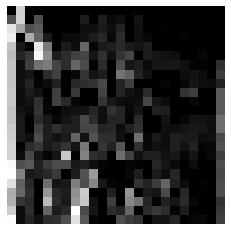

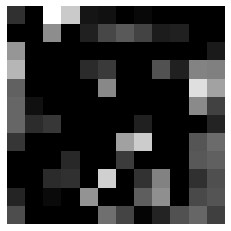

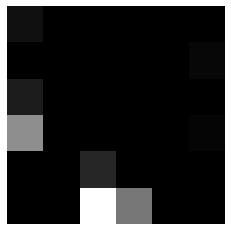

In [16]:
# Calculating the accuracy of the network on the whole dataset
correct = 0
total = 0
i = 0

# Setting network in evaluation/testing mode (for disabling dropout layers)
net.eval()

with torch.no_grad():
    for data in test_dataloader:
        
        images, labels = data # Getting the test data

        images = images.permute(0, 3, 1, 2)
        # Moving to device (cuda if available)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images) # Getting the network output
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
accurcyMean=100 * correct / total
              
print('Accuracy of the network on the %d test images (Public test-set): %d %%' % (len(imgs_test), accurcyMean))

# showing accumulated (convs) plots
plot.show()

Accuracy of Anger >:( (Class: 0): 	 76 %
Accuracy of Disgust :S (Class: 1): 	  0 %
Accuracy of Fear :"( (Class: 2): 	 45 %
Accuracy of Happiness :D (Class: 3): 	 97 %
Accuracy of Sadness :( (Class: 4): 	 52 %
Accuracy of Surprise :O (Class: 5): 	 94 %
Accuracy of Neutral :| (Class: 6): 	 75 %


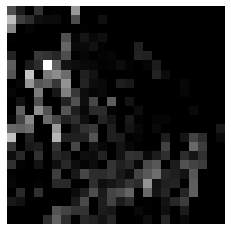

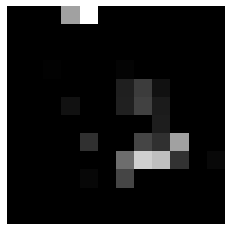

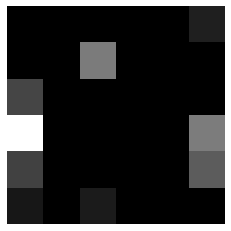

In [17]:
classes=len(np.unique(y_test))

#Calculating the accuracy of the network on each class of images
class_correct = list(0. for i in range(classes))
class_total = list(0. for i in range(classes))

net.eval()

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data # Getting the test data

        images=images.permute(0,3,1,2)

        images=images.to(device)
        labels=labels.to(device)
        
        outputs = net(images) # Getting the network output
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(5):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            if(class_total[label] == 0): print(":C")

accuracy=list(0. for i in range(classes))

for i in range(classes):
    accuracy[i] = 100 * (class_correct[i] / (class_total[i]+1))

for i in range(len(np.unique(y_test))):
    print('Accuracy of %s (Class: %s): \t %2d %%' % (emotions_labels_to_text[i],np.unique(y_test)[i], 100 * class_correct[i] / class_total[i]))

Precision of     0 : 55 %
Precision of     1 :  0 %
Precision of     2 : 59 %
Precision of     3 : 83 %
Precision of     4 : 55 %
Precision of     5 : 81 %
Precision of     6 : 58 %
Recall of     0 : 61 %
Recall of     1 :  0 %
Recall of     2 : 45 %
Recall of     3 : 85 %
Recall of     4 : 60 %
Recall of     5 : 79 %
Recall of     6 : 63 %


      recall  precision   accuracy
0  61.324786  55.728155  74.074074
1   0.000000   0.000000   0.000000
2  45.472837  59.788360  43.478261
3  85.714286  83.027027  94.736842
4  60.397554  55.633803  50.000000
5  79.807692  81.173594  90.000000
6  63.651316  58.814590  71.428571
Accuracy 	 66


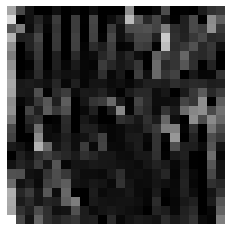

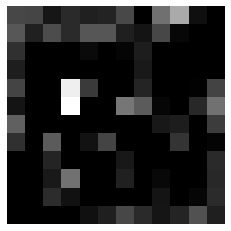

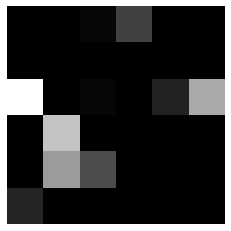

In [18]:
#Calculating the accuracy of the network on each class of images
class_true_positive = list(0. for i in range(classes))
class_false_positive = list(0. for i in range(classes))

class_true_negative = list(0. for i in range(classes))
class_false_negative = list(0. for i in range(classes))

net.eval()

for i in range(classes):
    for data in test_dataloader:
        images, labels = data # Getting the test data

        images=images.permute(0,3,1,2)

        images=images.to(device)
        labels=labels.to(device)
        
        outputs = net(images) # Getting the network output
        _, predicted = torch.max(outputs, 1)
        for j in range(len(labels)):
            if labels[j]==i:
                if predicted[j]==i:
                    class_true_positive[i]+=1
                else:
                    class_false_negative[i]+=1
            else:
                if predicted[j]==i:
                    class_false_positive[i]+=1
                    
precision = list(0. for i in range(classes))
recall = list(0. for i in range(classes))

for i in range(classes):
    precision[i]= 100 * class_true_positive[i] / (class_true_positive[i] + class_false_positive[i]+1)

for i in range(len(np.unique(y_test))):
    print('Precision of %5s : %2d %%' % (
        np.unique(y_test)[i], precision[i]))

for i in range(classes):
    recall[i]=100 * class_true_positive[i] / (class_true_positive[i] + class_false_negative[i]+1)

for i in range(len(np.unique(y_test))):
    print('Recall of %5s : %2d %%' % (
        np.unique(y_test)[i], recall[i]))

print("\n")

info={'recall':recall,'precision':precision,'accuracy':accuracy}
infoDF=pd.DataFrame(data=info)
print(infoDF)
print("Accuracy \t %d"%(accurcyMean))